# GRAPE LEAF DISEASES CLASSIFICATION
### ABSTRACT
**_Grapes can be grown in most parts of Turkey. It is produced intensively, especially in Manisa/Alaşehir, the city where I live.My father and mother are agricultural engineers and they are trying to find solutions for this issue but if these can be detected early.It will be easier to do this on large terrains with the drone..When I took this project, I wanted to help them in this issue.This project is to classify diseases data and healthy data.I'm going to do here is my next project, "Grape Leaf Detection in Real Time with Drone" and this is my graduation thesis.The rate of success in classification is very high and this situation is more successful for my think than a person._**

<img src="https://debuggercafe.com/wp-content/uploads/2019/12/Deep-Learning-with-PyTorch_-Image-Classification-using-Neural-Networks-e1575723823498.jpg" width="600" height="300" />

In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset 
from torchvision.datasets import ImageFolder
import torch.optim as optim 
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm

- **CUDA allows the code to be executed by the GPU. And first we look at whether we are using the GPU or the CPU. And if you have an NVIDIA graphics card, CUDA can be used.**
- **We take the data and break the data (train, test, labels).**
- **We are checking if there is an error in the number of images in the dataset.**
- **We take the data and split the data (train, test, labels).**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu
print(device)

dataset= datasets.ImageFolder(r'/home/ege/WORKSPACE/deepLearning/datasets/grape_leaf_new/Grapes Leaves Dataset (images)/train')
train_data, test_data, train_label, test_label = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42)

for index,value in enumerate(dataset.samples):
    dataset_index=index
dataset_index

cuda


3208


- **This class is generally used in most CNNs. Because the data is checked in connection with each other in a single class. If it is not binary, it is perceived as data.(Only RGB)**

In [3]:
class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.checkChannel(dataset) # some images are Grayscale, check only RGB 
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        classCategory = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, classCategory
        
    
    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            if (Image.open(dataset[index][0]).getbands() == ("R", "G", "B")): # Check Channels
                datasetRGB.append(dataset[index])
        return datasetRGB

## Transform and Data Loader
- **In the picture below, the transform is clearly understood. Coloring is applied to the pictures and some parts are cut randomly, and blur is added to it,etc.**
- **We apply transform to test data and train data. We enter the ImageLoader class.**
- **Finally, we determine the batch_size to prepare our data for training and testing. And we mix the data with the shuffle process.**

- ![transform](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_thumb.png)


In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_trans = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

test_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_dataset = ImageLoader(train_data, train_trans)
test_dataset = ImageLoader(test_data, test_trans)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=8, shuffle=True)

/home/ege/anaconda3/envs/deepLearning/lib/python3.9/site-packages/torchvision/transforms/transforms.py:935: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
/home/ege/anaconda3/envs/deepLearning/lib/python3.9/site-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


## Model
- **I used Resnet50, a ready-made model.Normally, as the complexity increases, there may be distortions. Resnet50 is a model that finds solutions to these.**
- **This criterion computes the cross entropy loss between input and target.Parameters are optionally contained within themselves.**
- **Implements stochastic gradient descent (optionally with momentum).SGD is slower than other optims.**
- **Set the learning rate of each parameter group using a cosine annealing schedule, where ηmaxis set to the initial lr and Tcur is the number of epochs since the last restart in SGDR:**

![alt text](https://miro.medium.com/max/400/1*QliXNPvhajME5ysUXfPROA.gif)

In [5]:
from torchvision.models import resnet50

model = resnet50(pretrained=True).cuda()

for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
    nn.Linear(2048, 270),
    nn.ReLU(inplace=True),
    nn.Linear(270, 90),
    nn.ReLU(inplace=True),
    nn.Linear(90, 4)).cuda()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) #T_max= Maximum number of iterations.

## Train-Test

In [6]:
train_accu=[]
losses_train = []
def train(epoch):
    loop = tqdm(enumerate(train_loader), total=len(train_loader)) # create a progress bar
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        losses_train.append(loss)
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        loop.set_description(f"Epoch {epoch+1}/{last_epoch} process: {int((batch_idx / len(train_loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item()) 
    accuracy_train = int(correct / len(train_loader.dataset) * 100)
    train_accu.append(accuracy_train)



    
best_acc = 0 
losses_test = []
y_true=[]
y_pred=[]
eval_accu=[]
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            losses_test.append(test_loss)
            y_true.append(targets)
            y_pred.append(predicted)

    accuracy_test =int(correct / len(test_loader.dataset) * 100)
    eval_accu.append(accuracy_test)
    print("Average Loss: ", test_loss, "  Accuracy: ", correct, " / ",
    len(test_loader.dataset), "  ", int(correct / len(test_loader.dataset) * 100), "%")

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc




In [7]:

start_epoch = 0
last_epoch=200
for epoch in range(start_epoch, last_epoch):
    train(epoch)
    test(epoch)
    scheduler.step()

Epoch 1/200 process: 99:   0%|          | 0/161 [00:13<?, ?it/s, loss=0.422] 


Average Loss:  18.492394021246582   Accuracy:  581  /  642    90 %
Saving..


Epoch 2/200 process: 99:   0%|          | 0/161 [00:13<?, ?it/s, loss=0.0165]


Average Loss:  7.077695869607851   Accuracy:  624  /  642    97 %
Saving..


Epoch 3/200 process: 99:   0%|          | 0/161 [00:13<?, ?it/s, loss=0.317]  


Average Loss:  4.994800050393678   Accuracy:  626  /  642    97 %
Saving..


Epoch 4/200 process: 99:   0%|          | 0/161 [00:13<?, ?it/s, loss=0.623] 


Average Loss:  4.830947917886078   Accuracy:  630  /  642    98 %
Saving..


Epoch 5/200 process: 99:   0%|          | 0/161 [00:13<?, ?it/s, loss=0.193] 


Average Loss:  5.539250005691429   Accuracy:  624  /  642    97 %


Epoch 6/200 process: 99:   0%|          | 0/161 [00:13<?, ?it/s, loss=0.703]  


Average Loss:  6.854882952902699   Accuracy:  620  /  642    96 %


Epoch 7/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.232]  


Average Loss:  9.927150383824483   Accuracy:  618  /  642    96 %


Epoch 8/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.503]   


Average Loss:  20.13219346711412   Accuracy:  581  /  642    90 %


Epoch 9/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0533] 


Average Loss:  4.277680449129548   Accuracy:  629  /  642    97 %


Epoch 10/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.247]  


Average Loss:  6.320818393054651   Accuracy:  625  /  642    97 %


Epoch 11/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0991] 


Average Loss:  4.191336158430204   Accuracy:  631  /  642    98 %
Saving..


Epoch 12/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.041]  


Average Loss:  7.171504183595516   Accuracy:  622  /  642    96 %


Epoch 13/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.85]   


Average Loss:  7.839595607452793   Accuracy:  617  /  642    96 %


Epoch 14/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.424]  


Average Loss:  4.00391075987136   Accuracy:  630  /  642    98 %


Epoch 15/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.027]  


Average Loss:  6.640111928456463   Accuracy:  627  /  642    97 %


Epoch 16/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.332]   


Average Loss:  4.851075903396122   Accuracy:  626  /  642    97 %


Epoch 17/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0224] 


Average Loss:  5.748080530902371   Accuracy:  628  /  642    97 %


Epoch 18/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.501]  


Average Loss:  5.798719442675065   Accuracy:  623  /  642    97 %


Epoch 19/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.47]   


Average Loss:  12.371836547885323   Accuracy:  607  /  642    94 %


Epoch 20/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0527] 


Average Loss:  7.606135042500682   Accuracy:  621  /  642    96 %


Epoch 21/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=1.16]   


Average Loss:  5.7795638111492735   Accuracy:  626  /  642    97 %


Epoch 22/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.175]  


Average Loss:  3.85009372595232   Accuracy:  632  /  642    98 %
Saving..


Epoch 23/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.375]  


Average Loss:  4.7778965518809855   Accuracy:  629  /  642    97 %


Epoch 24/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.267]  


Average Loss:  3.7105275511275977   Accuracy:  635  /  642    98 %
Saving..


Epoch 25/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0908] 


Average Loss:  5.245865196309751   Accuracy:  633  /  642    98 %


Epoch 26/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00602]


Average Loss:  3.9054089310411655   Accuracy:  631  /  642    98 %


Epoch 27/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.157]  


Average Loss:  5.454560677768313   Accuracy:  627  /  642    97 %


Epoch 28/200 process: 99:   0%|          | 0/161 [00:13<?, ?it/s, loss=0.031]  


Average Loss:  3.06506940536201   Accuracy:  633  /  642    98 %


Epoch 29/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0551] 


Average Loss:  4.538744810037315   Accuracy:  630  /  642    98 %


Epoch 30/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.336]  


Average Loss:  3.1045762744324747   Accuracy:  633  /  642    98 %


Epoch 31/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00896]


Average Loss:  6.451401525322581   Accuracy:  625  /  642    97 %


Epoch 32/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.259]  


Average Loss:  4.805622805200983   Accuracy:  627  /  642    97 %


Epoch 33/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.101]  


Average Loss:  5.827027675113641   Accuracy:  626  /  642    97 %


Epoch 34/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0857] 


Average Loss:  3.7810796263365773   Accuracy:  632  /  642    98 %


Epoch 35/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.162]  


Average Loss:  3.581820932624396   Accuracy:  634  /  642    98 %


Epoch 36/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00427]


Average Loss:  3.1474253598134965   Accuracy:  633  /  642    98 %


Epoch 37/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.137]  


Average Loss:  3.750293948702165   Accuracy:  633  /  642    98 %


Epoch 38/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.701]  


Average Loss:  3.261726882759831   Accuracy:  631  /  642    98 %


Epoch 39/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.348]  


Average Loss:  14.93848945026184   Accuracy:  598  /  642    93 %


Epoch 40/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.805]  


Average Loss:  5.902409602807893   Accuracy:  625  /  642    97 %


Epoch 41/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00208]


Average Loss:  3.2099743906292133   Accuracy:  632  /  642    98 %


Epoch 42/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.132]  


Average Loss:  6.259777083789231   Accuracy:  623  /  642    97 %


Epoch 43/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.135]  


Average Loss:  4.676968931540614   Accuracy:  629  /  642    97 %


Epoch 44/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.015]  


Average Loss:  3.0402309956843965   Accuracy:  633  /  642    98 %


Epoch 45/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0312]  


Average Loss:  3.1841908036585664   Accuracy:  633  /  642    98 %


Epoch 46/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0191] 


Average Loss:  2.9436468305648305   Accuracy:  635  /  642    98 %


Epoch 47/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00339]


Average Loss:  3.1361942170988186   Accuracy:  635  /  642    98 %


Epoch 48/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.202]  


Average Loss:  2.937279304358526   Accuracy:  634  /  642    98 %


Epoch 49/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.202]  


Average Loss:  3.9665841522938763   Accuracy:  633  /  642    98 %


Epoch 50/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.224]   


Average Loss:  3.9178811829769984   Accuracy:  631  /  642    98 %


Epoch 51/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.262]  


Average Loss:  3.7436312964127865   Accuracy:  632  /  642    98 %


Epoch 52/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0233] 


Average Loss:  2.391219555884163   Accuracy:  636  /  642    99 %
Saving..


Epoch 53/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.174]  


Average Loss:  4.2499684369249735   Accuracy:  630  /  642    98 %


Epoch 54/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0936] 


Average Loss:  3.7816816800041124   Accuracy:  635  /  642    98 %


Epoch 55/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.155]  


Average Loss:  2.5038994302012725   Accuracy:  634  /  642    98 %


Epoch 56/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.311]  


Average Loss:  6.644224802032113   Accuracy:  622  /  642    96 %


Epoch 57/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.659]   


Average Loss:  3.32566499710083   Accuracy:  634  /  642    98 %


Epoch 58/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.153]  


Average Loss:  2.519091382448096   Accuracy:  635  /  642    98 %


Epoch 59/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0997] 


Average Loss:  4.146276662359014   Accuracy:  632  /  642    98 %


Epoch 60/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0288] 


Average Loss:  2.4538070352282375   Accuracy:  635  /  642    98 %


Epoch 61/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00767] 


Average Loss:  2.2904713941206865   Accuracy:  636  /  642    99 %


Epoch 62/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0218] 


Average Loss:  4.780449440801931   Accuracy:  627  /  642    97 %


Epoch 63/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00499]


Average Loss:  4.481732961256057   Accuracy:  633  /  642    98 %


Epoch 64/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00508]


Average Loss:  2.503018836272531   Accuracy:  636  /  642    99 %


Epoch 65/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.018]  


Average Loss:  3.991612567566335   Accuracy:  630  /  642    98 %


Epoch 66/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00584]


Average Loss:  2.7562055477465037   Accuracy:  634  /  642    98 %


Epoch 67/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.087]   


Average Loss:  2.4378443078785494   Accuracy:  636  /  642    99 %


Epoch 68/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.237]   


Average Loss:  6.360141332726926   Accuracy:  623  /  642    97 %


Epoch 69/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0174] 


Average Loss:  2.4326438779680757   Accuracy:  634  /  642    98 %


Epoch 70/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.68]    


Average Loss:  2.7990705072486435   Accuracy:  635  /  642    98 %


Epoch 71/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.128]   


Average Loss:  5.109139130479889   Accuracy:  626  /  642    97 %


Epoch 72/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0596]  


Average Loss:  2.4445218814562395   Accuracy:  632  /  642    98 %


Epoch 73/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.501]   


Average Loss:  3.859087562697823   Accuracy:  631  /  642    98 %


Epoch 74/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.065]   


Average Loss:  2.451320368796587   Accuracy:  636  /  642    99 %


Epoch 75/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.189]  


Average Loss:  2.4422981693642214   Accuracy:  634  /  642    98 %


Epoch 76/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.202]   


Average Loss:  2.0493116158395424   Accuracy:  635  /  642    98 %


Epoch 77/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.283]  


Average Loss:  12.203204013290815   Accuracy:  603  /  642    93 %


Epoch 78/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.505]  


Average Loss:  2.803966345757999   Accuracy:  631  /  642    98 %


Epoch 79/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0263] 


Average Loss:  2.5207147050023195   Accuracy:  636  /  642    99 %


Epoch 80/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.13]   


Average Loss:  3.687621271921671   Accuracy:  630  /  642    98 %


Epoch 81/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.893]  


Average Loss:  5.736425588198472   Accuracy:  626  /  642    97 %


Epoch 82/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.024]   


Average Loss:  4.888461137168633   Accuracy:  624  /  642    97 %


Epoch 83/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.000995]


Average Loss:  3.123454172458878   Accuracy:  631  /  642    98 %


Epoch 84/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0181] 


Average Loss:  3.3020298628907767   Accuracy:  634  /  642    98 %


Epoch 85/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.217]   


Average Loss:  5.719829698727153   Accuracy:  626  /  642    97 %


Epoch 86/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00502] 


Average Loss:  2.993282153885957   Accuracy:  630  /  642    98 %


Epoch 87/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00356]


Average Loss:  7.431535553652793   Accuracy:  620  /  642    96 %


Epoch 88/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.454]   


Average Loss:  4.7005143461574335   Accuracy:  626  /  642    97 %


Epoch 89/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0134]  


Average Loss:  7.368746957974508   Accuracy:  613  /  642    95 %


Epoch 90/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0342] 


Average Loss:  3.5725848110741936   Accuracy:  633  /  642    98 %


Epoch 91/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.923]   


Average Loss:  2.516403890636866   Accuracy:  635  /  642    98 %


Epoch 92/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.205]  


Average Loss:  2.6168817880115967   Accuracy:  631  /  642    98 %


Epoch 93/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.484]  


Average Loss:  1.9962517374981417   Accuracy:  637  /  642    99 %
Saving..


Epoch 94/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00709] 


Average Loss:  8.51535534998402   Accuracy:  619  /  642    96 %


Epoch 95/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0162]  


Average Loss:  2.6571173445126988   Accuracy:  635  /  642    98 %


Epoch 96/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.119]   


Average Loss:  2.0125694037706126   Accuracy:  634  /  642    98 %


Epoch 97/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0529] 


Average Loss:  2.3496737758541713   Accuracy:  636  /  642    99 %


Epoch 98/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0182] 


Average Loss:  3.0896276489766024   Accuracy:  632  /  642    98 %


Epoch 99/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.318]  


Average Loss:  2.9748579577735654   Accuracy:  635  /  642    98 %


Epoch 100/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0294] 


Average Loss:  2.1596237773119356   Accuracy:  636  /  642    99 %


Epoch 101/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.108]  


Average Loss:  4.222807637532242   Accuracy:  629  /  642    97 %


Epoch 102/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0336]  


Average Loss:  6.172647534171119   Accuracy:  621  /  642    96 %


Epoch 103/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00606]


Average Loss:  2.3961847341488465   Accuracy:  634  /  642    98 %


Epoch 104/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0199]  


Average Loss:  2.775698008317704   Accuracy:  635  /  642    98 %


Epoch 105/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.349]   


Average Loss:  2.124005837671575   Accuracy:  636  /  642    99 %


Epoch 106/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0491] 


Average Loss:  3.0685992855287623   Accuracy:  632  /  642    98 %


Epoch 107/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00288] 


Average Loss:  2.1362254971681978   Accuracy:  635  /  642    98 %


Epoch 108/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.39]    


Average Loss:  3.5592452848359244   Accuracy:  633  /  642    98 %


Epoch 109/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.000926]


Average Loss:  1.8799309900314256   Accuracy:  638  /  642    99 %
Saving..


Epoch 110/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.114]  


Average Loss:  2.8080554714106256   Accuracy:  633  /  642    98 %


Epoch 111/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00448] 


Average Loss:  4.61022852028691   Accuracy:  628  /  642    97 %


Epoch 112/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0211] 


Average Loss:  2.6084830531549414   Accuracy:  636  /  642    99 %


Epoch 113/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.436]   


Average Loss:  2.6628633313957835   Accuracy:  634  /  642    98 %


Epoch 114/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0319] 


Average Loss:  2.189816992628039   Accuracy:  636  /  642    99 %


Epoch 115/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0102] 


Average Loss:  3.692971123960888   Accuracy:  631  /  642    98 %


Epoch 116/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0741]  


Average Loss:  2.0287290765845682   Accuracy:  638  /  642    99 %


Epoch 117/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.392]   


Average Loss:  4.472683190535463   Accuracy:  630  /  642    98 %


Epoch 118/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0143] 


Average Loss:  1.7727397797862068   Accuracy:  637  /  642    99 %


Epoch 119/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00929]


Average Loss:  4.515401853622507   Accuracy:  629  /  642    97 %


Epoch 120/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.101]   


Average Loss:  7.150894611389958   Accuracy:  619  /  642    96 %


Epoch 121/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0114] 


Average Loss:  2.9745724043114024   Accuracy:  632  /  642    98 %


Epoch 122/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.02]    


Average Loss:  2.3707628259217017   Accuracy:  635  /  642    98 %


Epoch 123/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00114] 


Average Loss:  2.68372747504327   Accuracy:  635  /  642    98 %


Epoch 124/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0309] 


Average Loss:  2.3512737350138195   Accuracy:  636  /  642    99 %


Epoch 125/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0211] 


Average Loss:  2.067820250249497   Accuracy:  636  /  642    99 %


Epoch 126/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0216]  


Average Loss:  3.986928734739138   Accuracy:  631  /  642    98 %


Epoch 127/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.285]   


Average Loss:  4.5155897448621545   Accuracy:  630  /  642    98 %


Epoch 128/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00915] 


Average Loss:  2.0617368931161764   Accuracy:  637  /  642    99 %


Epoch 129/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0781]  


Average Loss:  2.595943298380007   Accuracy:  634  /  642    98 %


Epoch 130/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00712] 


Average Loss:  2.950547358355834   Accuracy:  636  /  642    99 %


Epoch 131/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.579]   


Average Loss:  2.401971484789101   Accuracy:  635  /  642    98 %


Epoch 132/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0243]  


Average Loss:  5.483928155192189   Accuracy:  626  /  642    97 %


Epoch 133/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00021] 


Average Loss:  2.0392490196827566   Accuracy:  635  /  642    98 %


Epoch 134/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0239] 


Average Loss:  2.2612210072438756   Accuracy:  636  /  642    99 %


Epoch 135/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=1.04]   


Average Loss:  2.1890950780070852   Accuracy:  637  /  642    99 %


Epoch 136/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0301]  


Average Loss:  4.088359825237603   Accuracy:  631  /  642    98 %


Epoch 137/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00324]


Average Loss:  2.9961603096580802   Accuracy:  634  /  642    98 %


Epoch 138/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.027]  


Average Loss:  2.5692606725278893   Accuracy:  635  /  642    98 %


Epoch 139/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00427] 


Average Loss:  2.401579559151287   Accuracy:  634  /  642    98 %


Epoch 140/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0139] 


Average Loss:  2.268120654000086   Accuracy:  634  /  642    98 %


Epoch 141/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00052] 


Average Loss:  2.4281327570338362   Accuracy:  636  /  642    99 %


Epoch 142/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0154]  


Average Loss:  2.2513656845558216   Accuracy:  637  /  642    99 %


Epoch 143/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0131]  


Average Loss:  2.0571101704881585   Accuracy:  636  /  642    99 %


Epoch 144/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00046] 


Average Loss:  5.416034224182113   Accuracy:  629  /  642    97 %


Epoch 145/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0048] 


Average Loss:  2.1896694131755794   Accuracy:  637  /  642    99 %


Epoch 146/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.113]   


Average Loss:  2.85463364028692   Accuracy:  634  /  642    98 %


Epoch 147/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00547]


Average Loss:  4.183452399960515   Accuracy:  629  /  642    97 %


Epoch 148/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.123]  


Average Loss:  2.6953035351616563   Accuracy:  635  /  642    98 %


Epoch 149/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00213] 


Average Loss:  2.926496300224244   Accuracy:  634  /  642    98 %


Epoch 150/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0846]  


Average Loss:  4.341457557842659   Accuracy:  629  /  642    97 %


Epoch 151/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.000318]


Average Loss:  2.9464440603504727   Accuracy:  634  /  642    98 %


Epoch 152/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00783] 


Average Loss:  2.4511029775621864   Accuracy:  634  /  642    98 %


Epoch 153/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0765] 


Average Loss:  3.3264718564132636   Accuracy:  634  /  642    98 %


Epoch 154/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0293] 


Average Loss:  3.6910743548705796   Accuracy:  633  /  642    98 %


Epoch 155/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0325]  


Average Loss:  2.1382692019324168   Accuracy:  635  /  642    98 %


Epoch 156/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.228]   


Average Loss:  2.7122884655254893   Accuracy:  635  /  642    98 %


Epoch 157/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00838]


Average Loss:  2.352209811891953   Accuracy:  636  /  642    99 %


Epoch 158/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0396] 


Average Loss:  4.2245997648137745   Accuracy:  631  /  642    98 %


Epoch 159/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.315]   


Average Loss:  2.6725569648696705   Accuracy:  634  /  642    98 %


Epoch 160/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0402]  


Average Loss:  1.6940648595336825   Accuracy:  636  /  642    99 %


Epoch 161/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00335]


Average Loss:  2.0000765054537624   Accuracy:  636  /  642    99 %


Epoch 162/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0082]  


Average Loss:  3.1321942151080293   Accuracy:  632  /  642    98 %


Epoch 163/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0124]  


Average Loss:  2.374103545802427   Accuracy:  636  /  642    99 %


Epoch 164/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00195] 


Average Loss:  3.467518982216916   Accuracy:  634  /  642    98 %


Epoch 165/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0494]  


Average Loss:  2.3344428903001244   Accuracy:  636  /  642    99 %


Epoch 166/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0126] 


Average Loss:  1.8143569709936855   Accuracy:  637  /  642    99 %


Epoch 167/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0952]  


Average Loss:  1.8476071370969294   Accuracy:  638  /  642    99 %


Epoch 168/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0427]  


Average Loss:  2.614638364984785   Accuracy:  633  /  642    98 %


Epoch 169/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00522]


Average Loss:  2.505647185116686   Accuracy:  635  /  642    98 %


Epoch 170/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0183] 


Average Loss:  2.036543735194755   Accuracy:  637  /  642    99 %


Epoch 171/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.009]   


Average Loss:  2.3077918954077177   Accuracy:  635  /  642    98 %


Epoch 172/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.138]   


Average Loss:  2.6198430079239188   Accuracy:  633  /  642    98 %


Epoch 173/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.27]   


Average Loss:  3.87209887844665   Accuracy:  630  /  642    98 %


Epoch 174/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00668] 


Average Loss:  1.9838159497139713   Accuracy:  637  /  642    99 %


Epoch 175/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.549]   


Average Loss:  1.8587714238019544   Accuracy:  638  /  642    99 %


Epoch 176/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0442] 


Average Loss:  2.452621495551284   Accuracy:  635  /  642    98 %


Epoch 177/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00576] 


Average Loss:  2.63016254271497   Accuracy:  635  /  642    98 %


Epoch 178/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00237] 


Average Loss:  2.7335281321866205   Accuracy:  634  /  642    98 %


Epoch 179/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.053]  


Average Loss:  2.926372931779042   Accuracy:  634  /  642    98 %


Epoch 180/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00884] 


Average Loss:  1.6566686172791378   Accuracy:  638  /  642    99 %


Epoch 181/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.115]  


Average Loss:  3.04949896447215   Accuracy:  633  /  642    98 %


Epoch 182/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.154]   


Average Loss:  2.5717477545529164   Accuracy:  635  /  642    98 %


Epoch 183/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00901] 


Average Loss:  1.9461366383948189   Accuracy:  637  /  642    99 %


Epoch 184/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00154] 


Average Loss:  4.305921637640495   Accuracy:  633  /  642    98 %


Epoch 185/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00935] 


Average Loss:  3.309935758519714   Accuracy:  633  /  642    98 %


Epoch 186/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0262] 


Average Loss:  3.0681328852824663   Accuracy:  634  /  642    98 %


Epoch 187/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.261]   


Average Loss:  2.1207304576946626   Accuracy:  635  /  642    98 %


Epoch 188/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0143]  


Average Loss:  2.0379781932201695   Accuracy:  638  /  642    99 %


Epoch 189/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0505]  


Average Loss:  2.07616896604668   Accuracy:  636  /  642    99 %


Epoch 190/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0365]  


Average Loss:  1.984245816085604   Accuracy:  636  /  642    99 %


Epoch 191/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0103]  


Average Loss:  2.1081603664988506   Accuracy:  637  /  642    99 %


Epoch 192/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0942]  


Average Loss:  2.777050384451286   Accuracy:  633  /  642    98 %


Epoch 193/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0404] 


Average Loss:  2.1948548158579797   Accuracy:  635  /  642    98 %


Epoch 194/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0507]  


Average Loss:  2.7192300001152034   Accuracy:  636  /  642    99 %


Epoch 195/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0118]  


Average Loss:  2.0179576597656705   Accuracy:  636  /  642    99 %


Epoch 196/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.31]    


Average Loss:  2.710764524050319   Accuracy:  635  /  642    98 %


Epoch 197/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00236] 


Average Loss:  2.6016785071478807   Accuracy:  634  /  642    98 %


Epoch 198/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.00213] 


Average Loss:  1.7001495297627116   Accuracy:  637  /  642    99 %


Epoch 199/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.0256]  


Average Loss:  2.047776258164049   Accuracy:  637  /  642    99 %


Epoch 200/200 process: 99:   0%|          | 0/161 [00:14<?, ?it/s, loss=0.302]  


Average Loss:  1.7432453534929664   Accuracy:  638  /  642    99 %


## Converting from tensor to list

In [8]:
y_true1=[]
for i in range(len(y_true)):
    for index,value in enumerate(y_true[i]):
        #print(index,value)
        y_true1.append(value.item())

y_pred1=[]
for i in range(len(y_pred)):
    for index,value in enumerate(y_pred[i]):
        #print(index,value)
        y_pred1.append(value.item())

## Plot Confusion Matrix

Confusion matrix, without normalization
[[41279  1614    71    36]
 [  361 44222    10     7]
 [   21     1  9550    28]
 [    0     9    13 31178]]


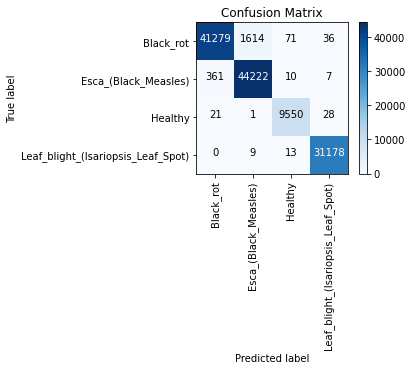

In [9]:

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pylab as plt

classes=dataset.classes

cm=confusion_matrix(y_true=y_true1,y_pred=y_pred1)


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm_plot_labels = [test_label]
plt.rcParams["figure.figsize"] = (6,5)
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix')



## Classification Report

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_true1, y_pred1,target_names=dataset.classes))

                                    precision    recall  f1-score   support

                         Black_rot       0.99      0.96      0.98     43000
              Esca_(Black_Measles)       0.96      0.99      0.98     44600
                           Healthy       0.99      0.99      0.99      9600
Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      1.00      1.00     31200

                          accuracy                           0.98    128400
                         macro avg       0.99      0.99      0.99    128400
                      weighted avg       0.98      0.98      0.98    128400



- **First, we convert the tensors to get rid of the redundancy inside. Then we append the tensors as a list again.**

In [11]:
losses1=[]
losses1.append(torch.Tensor(losses_train))
losses2=[]
for i in range(len(losses1)):
    for index,value in enumerate(losses1[i]):
        #print(index,value)
        losses2.append(value.item())

## Learning Curve

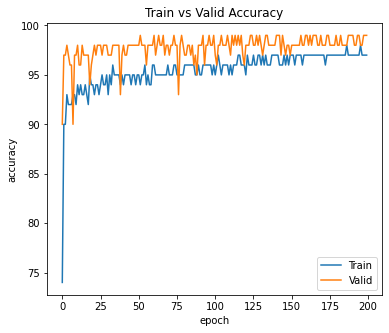

In [12]:
plt.plot(train_accu)
plt.plot(eval_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()
 